# Project 2 - Dynamic Programming

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Presets across all senarios
allow_no_coach_sale=False # For scenario 3
seasonal_demand=False    # For scenario 4
coach_seats=100          # Fixed across all scenarios
first_class_seats=20     # Fixed across all scenarios
coach_prices=[300, 350]  # Fixed across all scenarios
first_class_prices=[425, 500] # Fixed across all scenarios
coach_show_prob=0.95    # Fixed across all scenarios 
first_class_show_prob=0.97 # Fixed across all scenarios
coach_demand_prob=[0.65, 0.30] # Base probabilities
coach_demand_increase=0.03 # Coach demand increase when first-class sold out
first_class_demand_prob=[0.08, 0.04] # Base probabilities
bump_cost=50             # Cost to bump to first-class
denied_cost=425          # Cost to deny boarding
days=365                 # days until flight
discount_rate=0.17       # used to discount profit from selling tickets at time t

# could create a dictionary to store these values instead and make the functions below look better

## Scenario 1:
### Given:
- 365 days until plane departs
- 100 seats in coach and 20 seats in first class
- Show passengers
    - P(first-class passenger shows) = .97
    - P(coach passenger shows) = .95
- Ticket prices:
    - Coach = \$300 or \$350
    - First = \$425 or \$500
- Ticket demand:
    - Can sell 0 or 1 tickets for each class each day
    - Demand for coach and first-class independent
    - If there is more demand for first-class than there are tickets, customers won't buy a coach seat.
    - If there is more demand for coach than there are tickets, customers won't buy a first-class seat.
    - Coach
        - If price = \$300, then P(sale) = .65
        - If price = \$350, then P(sale) = .3
        - If first class is sold out and price = \$300, P(sale) = .68
        - If first class is sold out and price = $\350, P(sale) = .33
    - First
        - If price = \$425, then P(sale) = .08
        - If price = \$500, the P(sale) = .04
- Overbooking costs:
    - Coach is allowed to be oversold by 5 seats
    - Not allowed to overbook first class
    - \$50 to bump coach passengr to first class
    - \$425 to bump coach passenger off flight
- Discount factor
    - yearly $\delta = \frac{1}{.17}$
    - daily $\delta = \frac{1}{1+0.17/365}$
- Terminal condition
    - On the day the flight takes off, there is no revenue, only costs.

### Defining the dynamic program:

#### State variables
- State = (t, $c_t$, $f_t$)
- t = day (0,1,...,365)
- $c_t$ = total coach tickets sold at time t
- $f_t$ = total first class tickets sold at time t

#### Choice variables
- On each day you have 4 choices:
    - Coach price = \$300 or \$350
    - First-class price = \$425 or \$500
- This gives you 4 possible combinations each day:
    - (300, 425): low coach price, low first-class price
    - (300, 500): low coach price, high first-class price
    - (350, 425): high coach price, low first-class price
    - (350, 500): high coach price, high first-class price

#### Dynamics
- (t, $c_t$, $f_t$) ------> (t+1, $c_{t+1}$, $f_{t+1}$)
- Can sell either 0 or 1 coach tickets
- Can sell either 0 or 1 first-class tickets
- Number of tickets sold at time t+1 is dependent on the price chosen at time t:

$$
\text{Coach tickets sold at } t+1: \\
c_{t+1} = 
\begin{cases}
c_t + 1, & \text{with probability } P_c(p_c, f_t) \text{ if } c_t < \text{cap}_c \\
c_t, & \text{with probability } (1 - P_c(p_c, f_t)) \text{ or if } c_t = \text{cap}_c
\end{cases}
$$

$$
\text{First-class tickets sold at } t+1: \\
f_{t+1} = 
\begin{cases}
f_t + 1, & \text{with probability } P_f(p_f) \text{ if } f_t < 20 \\
f_t, & \text{with probability } (1 - P_f(p_f)) \text{ or if } f_t = 20
\end{cases}
$$

Where:
- $c_t$ = Number of coach tickets sold at time $t$
- $f_t$ = Number of first-class tickets sold at time $t$
- $c_{t+1}$ = Number of coach tickets sold at time $t+1$
- $f_{t+1}$ = Number of first-class tickets sold at time $t+1$
- $\text{cap}_c$ = Maximum allowed coach tickets (105 for the +5 oversold scenario)
- $p_c$ = Price of coach ticket, either $\$300$ or $\$350$
- $p_f$ = Price of first-class ticket, either $\$425$ or $\$500$
- $P_c(p_c, f_t)$ = Probability of selling a coach ticket at price $p_c$ given $f_t$ first-class tickets sold:
  * $P_c(300, f_t) = 0.65$ if $f_t < 20$, and $0.68$ if $f_t = 20$
  * $P_c(350, f_t) = 0.30$ if $f_t < 20$, and $0.33$ if $f_t = 20$
- $P_f(p_f, c_t)$ = Probability of selling a first-class ticket at price $p_f$:
  * $P_f(425) = 0.08$ 
  * $P_f(500) = 0.04$ 

#### Bellman equation
$$
V(t, c_t, f_t) = \max_{p_c, p_f} \{ \mathbb{E}[R_t + \delta \cdot V(t+1, c_{t+1}, f_{t+1})] \}
$$

Where:
- $V(t, c_t, f_t)$ = Maximum expected discounted profit from state $(t, c_t, f_t)$
- $c_t$ = Number of coach tickets sold at time $t$
- $f_t$ = Number of first-class tickets sold at time $t$
- $p_c$ = Price of coach ticket, either $\$300$ or $\$350$
- $p_f$ = Price of first-class ticket, either $\$425$ or $\$500$
- $R_t$ = Revenue at time $t$
- $\delta$ = Daily discount factor = $1/(1+0.17/365)$

We can expand the expectation by considering all possible combinations of ticket sales:

$$
V(t, c_t, f_t) = \max_{p_c, p_f} \left\{ 
\begin{aligned}
&P_c(p_c, f_t) \cdot P_f(p_f, c_t) \cdot [p_c + p_f + \delta \cdot V(t+1, c_t+1, f_t+1)] + \\
&P_c(p_c, f_t) \cdot (1-P_f(p_f, c_t)) \cdot [p_c + \delta \cdot V(t+1, c_t+1, f_t)] + \\
&(1-P_c(p_c, f_t)) \cdot P_f(p_f, c_t) \cdot [p_f + \delta \cdot V(t+1, c_t, f_t+1)] + \\
&(1-P_c(p_c, f_t)) \cdot (1-P_f(p_f, c_t)) \cdot [\delta \cdot V(t+1, c_t, f_t)]
\end{aligned}
\right\}
$$

With boundary conditions:
- If $c_t = \text{cap}_c$, then no more coach tickets can be sold
- If $f_t = 20$, then no more first-class tickets can be sold

##### Expanded Bellman Equation for All Price Combinations

We can further expand the Bellman equation to explicitly show all four pricing combination choices:

Let's denote the four pricing combinations as:
1. $(p_c, p_f) = (300, 425)$: Low coach price, low first-class price
2. $(p_c, p_f) = (300, 500)$: Low coach price, high first-class price
3. $(p_c, p_f) = (350, 425)$: High coach price, low first-class price
4. $(p_c, p_f) = (350, 500)$: High coach price, high first-class price

Then the Bellman equation becomes:

$$
V(t, c_t, f_t) = \max \left\{ V^{(300,425)}(t, c_t, f_t), V^{(300,500)}(t, c_t, f_t), V^{(350,425)}(t, c_t, f_t), V^{(350,500)}(t, c_t, f_t) \right\}
$$

Where each pricing strategy's value is:

$$
V^{(300,425)}(t, c_t, f_t) = 
\begin{aligned}
&P_c(300, f_t) \cdot P_f(425) \cdot [300 + 425 + \delta \cdot V(t+1, c_t+1, f_t+1)] + \\
&P_c(300, f_t) \cdot (1-P_f(425)) \cdot [300 + \delta \cdot V(t+1, c_t+1, f_t)] + \\
&(1-P_c(300, f_t)) \cdot P_f(425) \cdot [425 + \delta \cdot V(t+1, c_t, f_t+1)] + \\
&(1-P_c(300, f_t)) \cdot (1-P_f(425)) \cdot [\delta \cdot V(t+1, c_t, f_t)]
\end{aligned}
$$

Similar equations apply for the other three price combinations, with the appropriate price values substituted.

The probability values from the problem statement are:
- $P_c(300, f_t) = 0.65$ if $f_t < 20$, and $0.68$ if $f_t = 20$
- $P_c(350, f_t) = 0.30$ if $f_t < 20$, and $0.33$ if $f_t = 20$
- $P_f(425) = 0.08$
- $P_f(500) = 0.04$

With constraints applied when tickets are sold out:
- If $c_t = \text{cap}_c$, then $P_c(300, f_t) = P_c(350, f_t) = 0$
- If $f_t = 20$, then $P_f(425) = P_f(500) = 0$

This formulation allows us to systematically compute the expected value for each pricing strategy at every state and choose the optimal policy.

#### Terminal Condition (t = 365)
At t = 365 (day of flight departure), there are no more sales opportunities, and we only need to account for the expected overbooking costs:

$$
V(365, c_{365}, f_{365}) = -\mathbb{E}[\text{Overbooking costs}]
$$

This expectation can be expanded using the properties of expectations and binomial probability distributions:

$$
V(365, c_{365}, f_{365}) = -\sum_{i=0}^{c_{365}} \sum_{j=0}^{f_{365}} P(C=i) \cdot P(F=j) \cdot \text{Cost}(i, j)
$$

Where:
- $C$ = Number of coach passengers who show up (binomial with probability 0.95)
- $F$ = Number of first-class passengers who show up (binomial with probability 0.97)
- $P(C=i) = \binom{c_{365}}{i}(0.95)^i(0.05)^{c_{365}-i}$ 
- $P(F=j) = \binom{f_{365}}{j}(0.97)^j(0.03)^{f_{365}-j}$
- $\text{Cost}(i, j)$ = Overbooking cost for $i$ coach show-ups and $j$ first-class show-ups

The cost function is defined as:

$$
\text{Cost}(i, j) = 
\begin{cases}
0, & \text{if } i \leq 100 \\
50 \cdot \min(i-100, 20-j), & \text{if } 100 < i \leq 100 + (20-j) \\
50 \cdot (20-j) + 425 \cdot (i - 100 - (20-j)), & \text{if } i > 100 + (20-j)
\end{cases}
$$

This cost function accounts for the three possible scenarios:
1. Coach show-ups don't exceed capacity (100 seats) → No cost
2. Some coach passengers can be bumped to available first-class seats → $\$50$ per passenger
3. After filling available first-class seats, additional passengers must be denied boarding → $\$425$ per passenger

This terminal condition provides the base case for our forward dynamic programming solution process, starting from t = 1 and progressing to t = 365.


## Scenario 2
Same as scenario 1, except coach can be oversold by 6,7,8,...,15 seats.

Which overbooking policy leads to the largest profits by the airline?

## Scenario 3
Now assume that the airline can choose not to sell coach tickets on any given day, meaning there are 3 options for coach tickets each day: low price, high price, or no sale. There are still only two choices for first class: low or high price.

The airline will never sell more than 120 seats in coach, but on any one day they can choose to not sell coach tickets. This way they can stop over-selling tickets not just based on how many they have sold, but also on how many days are left to sell.

Does this policy have a better or worse expected profit than the best policy from step 2?

## Scenario 4
Now assume that as the time of departure gets closer, the demand for tickets increases. This is like seasonality. On each day t, for each ticket class, multiply the probability of a sale by $0.75 + t/730$. For example, on day t = 100 if you charge \$300 for a seat in coach and then the probability of a sale is 57.65% instead of 65%.

## Scenario 5
Now that you have solved the problem backwards, use the optimal overbooking policy to simulate the solution forward many times. How often is coach overbooked? How often are passengers kicked off the plane? What is the average overbooking cost? What is the volatility of discounted profits? Are there any other interesting questions you can think of? Make a few graphs to examine these questions. Do this for both policies above.

In [2]:
# Can calculate expected profit for any of the scenarios above using this function
def calculate_expected_profit(
    overbooking_level,        # Coach seats that can be overbooked
    allow_no_coach_sale=False, # Change for scenario 3
    seasonal_demand=False,    # Change for scenario 4
    # Set defaults for constant variables across scenarios based on presets
    coach_seats=coach_seats,          # Fixed across all scenarios
    first_class_seats=first_class_seats,     # Fixed across all scenarios
    coach_prices=coach_prices,  # Fixed across all scenarios
    first_class_prices=first_class_prices, # Fixed across all scenarios
    coach_show_prob=coach_show_prob,     # Fixed across all scenarios 
    first_class_show_prob=first_class_show_prob, # Fixed across all scenarios
    coach_demand_prob=coach_demand_prob, # Base probabilities
    coach_demand_increase=coach_demand_increase, # Coach demand increase when first-class sold out
    first_class_demand_prob=first_class_demand_prob, # Base probabilities
    bump_cost=bump_cost,             # Cost to bump to first-class
    denied_cost=denied_cost,          # Cost to deny boarding
    days=days,                 # Fixed across all scenarios
    discount_rate=discount_rate        # Fixed across all scenarios
):
    # Initial state
    t = days  # days until plane departs
    c = 0    # coach tickets sold
    f = 0    # first class tickets sold
    C = coach_seats  # number of coach seats
    F = first_class_seats   # number of first class seats
    delta = 1/(1+discount_rate/days)

    # Choice variables
    p_c = coach_prices 
    p_f = first_class_prices  # first-class prices

    # Dynamics
    P_c = coach_demand_prob  # probability of selling coach ticket at each price
    P_c_adj = np.array(P_c) + coach_demand_increase # coach probability increases if first-class sells out
    P_f = first_class_demand_prob  # probability of selling first-class ticket at each price

    # Terminal condition
    T = days
    c_cap = C + overbooking_level  # coach tickets that can be sold

    # All possible state values
    tValues = np.arange(T+1)  # all possible days until take off (0-365)
    cValues = np.arange(c_cap+1)  # 0 to (100 + overbooking_level) coach tickets sold
    fValues = np.arange(F+1)  # 0-20 first-class tickets sold
    
    # Count possible state values
    tN = len(tValues)  # 366
    cN = len(cValues)  # (101 + overbooking_level)
    fN = len(fValues)  # 21
    
    # Set up V and U matrices
    V = np.zeros((tN, cN, fN))  # 3D matrix 
    U = np.zeros((tN, cN, fN))
    
    # Terminal condition calculation
    for c_T in range(cN):
        for f_T in range(fN):
            exp_cost = 0
            for i in range(c_T + 1):
                for j in range(f_T + 1):
                    P_i = stats.binom.pmf(i, c_T, coach_show_prob)
                    P_j = stats.binom.pmf(j, f_T, first_class_show_prob)
                    if i <= C:  # less coach passengers show up than coach seats available
                        cost = 0
                    elif i <= C + (F - j):  # all extra coach passengers can be bumped to first-class
                        cost = bump_cost * (i - C)
                    else:  # some passengers must be denied boarding
                        cost = bump_cost * (F - j) + denied_cost * (i - C - (F - j))
                    exp_cost += P_i * P_j * cost
            V[tN-1, c_T, f_T] = -exp_cost
    
    # Solve the bellman equation
    for t in reversed(range(tN-1)):  # day 364 to 0
        # set the demand dependent on time if using seasonal demand
        if seasonal_demand:
            P_ct = np.array(P_c) * (.75 + t/730) # demand of coach at time t
            P_ct_adj = np.array(P_c_adj) * (.75 + t/730) # demand of coach at time t if first-class sold out
            P_ft = np.array(P_f) * (.75 + t/730) # demand of first class at time t
        else:
            P_ct = P_c # demand of coach at time t (constant)
            P_ct_adj = P_c_adj # demand of coach at time t if first-class sold out
            P_ft = P_f # demand of first class at time t
        for c in range(cN):  # 0 to (100 + overbooking_level) tickets sold
            for f in range(fN):  # 0 to 20 tickets sold
                if c == c_cap and f<F: # Can't sell more coach tickets, but can sell first-class
                    # Low first-class price
                    valueL = P_ft[0] * (p_f[0] + delta * V[t+1, c, f+1]) + (1-P_ft[0]) * delta * V[t+1, c, f]
                    # High first-class price
                    valueH = P_ft[1] * (p_f[1] + delta * V[t+1, c, f+1]) + (1-P_ft[1]) * delta * V[t+1, c, f]
                    V[t, c, f] = max(valueL, valueH)
                    if allow_no_coach_sale:
                        U[t, c, f] = np.argmax([valueL, valueH]) + 9  # 9 for -L, 10 for -H
                    else:
                        U[t, c, f] = np.argmax([valueL, valueH]) + 6  # 6 for -L, 7 for -H
                
                elif c == c_cap and f == F:  # Both at capacity
                    V[t, c, f] = delta * V[t+1, c, f]
                    if allow_no_coach_sale:
                        U[t, c, f] = 11  # No sale possible
                    else:
                        U[t, c, f] = 8 
                elif c < c_cap and f == F:  # First-class is sold out but coach isn't
                    # Low coach price
                    valueL = P_ct_adj[0] * (p_c[0] + delta * V[t+1, c+1, f]) + (1-P_ct_adj[0]) * delta * V[t+1, c, f]
                    # High coach price
                    valueH = P_ct_adj[1] * (p_c[1] + delta * V[t+1, c+1, f]) + (1-P_ct_adj[1]) * delta * V[t+1, c, f]
                    # No coach
                    valueN = delta * V[t+1, c, f]
                    
                    if allow_no_coach_sale:
                        V[t, c, f] = max(valueL, valueH, valueN)
                        U[t, c, f] = np.argmax([valueL, valueH, valueN]) + 6  # 6 for L-, 7 for H-, 8 for N-
                    else:
                        V[t, c, f] = max(valueL, valueH)
                        U[t, c, f] = np.argmax([valueL, valueH]) + 4  # 4 for L-, 5 for H-
                        
                
                else:  # Both ticket types can potentially be sold
                    # Calculate value for all four (six) price combinations (six combinations when no sale is allowed)
                    
                    # Low coach, Low first-class (LL)
                    # expected profit calculate across both, one, or neither ticket purchased
                    value_LL = P_ct[0] * P_ft[0] * (p_c[0] + p_f[0] + delta * V[t+1, c+1, f+1]) + \
                              P_ct[0] * (1-P_ft[0]) * (p_c[0] + delta * V[t+1, c+1, f]) + \
                              (1-P_ct[0]) * P_ft[0] * (p_f[0] + delta * V[t+1, c, f+1]) + \
                              (1-P_ct[0]) * (1-P_ft[0]) * delta * V[t+1, c, f]
                    
                    # Low coach, High first-class (LH)
                    # expected profit calculate across both, one, or neither ticket purchased
                    value_LH = P_ct[0] * P_ft[1] * (p_c[0] + p_f[1] + delta * V[t+1, c+1, f+1]) + \
                              P_ct[0] * (1-P_ft[1]) * (p_c[0] + delta * V[t+1, c+1, f]) + \
                              (1-P_ct[0]) * P_ft[1] * (p_f[1] + delta * V[t+1, c, f+1]) + \
                              (1-P_ct[0]) * (1-P_ft[1]) * delta * V[t+1, c, f]
                    
                    # High coach, Low first-class (HL)
                    # expected profit calculate across both, one, or neither ticket purchased
                    value_HL = P_ct[1] * P_ft[0] * (p_c[1] + p_f[0] + delta * V[t+1, c+1, f+1]) + \
                              P_ct[1] * (1-P_ft[0]) * (p_c[1] + delta * V[t+1, c+1, f]) + \
                              (1-P_ct[1]) * P_ft[0] * (p_f[0] + delta * V[t+1, c, f+1]) + \
                              (1-P_ct[1]) * (1-P_ft[0]) * delta * V[t+1, c, f]
                    
                    # High coach, High first-class (HH)
                    # expected profit calculate across both, one, or neither ticket purchased
                    value_HH = P_ct[1] * P_ft[1] * (p_c[1] + p_f[1] + delta * V[t+1, c+1, f+1]) + \
                              P_ct[1] * (1-P_ft[1]) * (p_c[1] + delta * V[t+1, c+1, f]) + \
                              (1-P_ct[1]) * P_ft[1] * (p_f[1] + delta * V[t+1, c, f+1]) + \
                              (1-P_ct[1]) * (1-P_ft[1]) * delta * V[t+1, c, f]

                    # No coach, Low first-class (NL)
                    # expected profit calculate across first-class purchased or not
                    value_NL = P_ft[0] * (p_f[0] + delta * V[t+1, c, f+1]) + \
                              (1-P_ft[0]) * delta * V[t+1, c, f]

                    # No coach, High first-class (NH)
                    # expected profit calculate across first-class purchased or not
                    value_NH =  P_ft[1] * (p_f[1] + delta * V[t+1, c, f+1]) + \
                              (1-P_ft[1]) * delta * V[t+1, c, f]
                    
                    if allow_no_coach_sale:
                        values = [value_LL, value_LH, value_HL, value_HH, value_NL, value_NH]
                        V[t, c, f] = max(values)
                        U[t, c, f] = np.argmax(values)  # 0 = LL, 1 = LH, 2 = HL, 3 = HH, 4 = NL, 5 = NH
                    else:
                        values = [value_LL, value_LH, value_HL, value_HH]
                        V[t, c, f] = max(values)
                        U[t, c, f] = np.argmax(values)  # 0 = LL, 1 = LH, 2 = HL, 3 = HH

    
    return V[0, 0, 0], V, U  # Return expected profit, value, and optimal decision matrix

# Function to simulate the solution forward once
def simulate_flight(
    U,        # Optimal decisions for each state from output of calculate_expected_profit
    allow_no_coach_sale, # MUST match the value used in calculate_expected_profit
    seasonal_demand,    # Must match the value used in calculate_expected_profit
    # Set defaults for constant variables across scenarios based on presets
    # If you change any of the below parameters in calculate_expected_profit, change here too
    coach_seats=coach_seats,          
    first_class_seats=first_class_seats,     
    coach_prices=coach_prices,  
    first_class_prices=first_class_prices,
    coach_show_prob=coach_show_prob,    
    first_class_show_prob=first_class_show_prob,
    coach_demand_prob=coach_demand_prob, # Base probabilities
    coach_demand_increase=coach_demand_increase, # Coach demand increase when first-class sold out
    first_class_demand_prob=first_class_demand_prob, # Base probabilities
    bump_cost=bump_cost,             # Cost to bump to first-class
    denied_cost=denied_cost,         # Cost to deny boarding
    days=days,                 
    discount_rate=discount_rate
):
    # Initial state
    t = 0  # days until plane departs
    c = 0    # coach tickets sold
    f = 0    # first class tickets sold
    C = coach_seats  # number of coach seats
    F = first_class_seats   # number of first class seats
    profit = 0
    delta = 1/(1+discount_rate/days)

    # Choice variables
    p_c = coach_prices 
    p_f = first_class_prices  # first-class prices

    # Dynamics
    P_c = coach_demand_prob  # probability of selling coach ticket at each price
    P_c_adj = np.array(P_c) + coach_demand_increase # coach probability increases if first-class sells out
    P_f = first_class_demand_prob  # probability of selling first-class ticket at each price

    # Terminal condition
    T = days
    # Get the overbooking level
    c_cap = U.shape[1] - 1 # coach tickets that can be sold
    
    for t in range(T-1):  # day 0 to 364
        # Set the demand dependent on time if using seasonal demand
        if seasonal_demand:
            P_ct = np.array(P_c) * (.75 + t/730)
            P_ct_adj = np.array(P_c_adj) * (.75 + t/730)
            P_ft = np.array(P_f) * (.75 + t/730)
        else:
            P_ct = P_c
            P_ct_adj = P_c_adj
            P_ft = P_f
        # Determine the price charged and demand for each day depending on the optimal policy
        # No sale is incporated into the U codes, so don't need to worry about the coach cap
        # Consider using a dictionary to make this look better!
        if allow_no_coach_sale:
            if U[t,c,f] == 0: # LL
                p_ct = p_c[0]
                P_ct_val = P_ct[0]
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 1: # LH
                p_ct = p_c[0]
                P_ct_val = P_ct[0]
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 2: # HL
                p_ct = p_c[1]
                P_ct_val = P_ct[1]
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 3: # HH
                p_ct = p_c[1]
                P_ct_val = P_ct[1]
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 4: # NL
                p_ct = None
                P_ct_val = None
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 5: # NH
                p_ct = None
                P_ct_val = None
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 6: # L-
                p_ct = p_c[0]
                P_ct_val = P_ct_adj[0]
                p_ft = None
                P_ft_val = None
            elif U[t,c,f] == 7: # H-
                p_ct = p_c[1]
                P_ct_val = P_ct_adj[1]
                p_ft = None
                P_ft_val = None
            elif U[t,c,f] == 8: # N-
                p_ct = None
                P_ct_val = None
                p_ft = None
                P_ft_val = None
            elif U[t,c,f] == 9: # -L
                p_ct = None
                P_ct_val = None
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 10: # -H
                p_ct = None
                P_ct_val = None
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 11: # no sale
                p_ct = None
                P_ct_val = None
                p_ft = None
                P_ft_val = None
        else:
            if U[t,c,f] == 0: # LL
                p_ct = p_c[0]
                P_ct_val = P_ct[0]
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 1: # LH
                p_ct = p_c[0]
                P_ct_val = P_ct[0]
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 2: # HL
                p_ct = p_c[1]
                P_ct_val = P_ct[1]
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 3: # HH
                p_ct = p_c[1]
                P_ct_val = P_ct[1]
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 4: # L-
                p_ct = p_c[0]
                P_ct_val = P_ct_adj[0]
                p_ft = None
                P_ft_val = None
            elif U[t,c,f] == 5: # H-
                p_ct = p_c[1]
                P_ct_val = P_ct_adj[1]
                p_ft = None
                P_ft_val = None
            elif U[t,c,f] == 6: # -L
                p_ct = None
                P_ct_val = None
                p_ft = p_f[0]
                P_ft_val = P_ft[0]
            elif U[t,c,f] == 7: # -H
                p_ct = None
                P_ct_val = None
                p_ft = p_f[1]
                P_ft_val = P_ft[1]
            elif U[t,c,f] == 8: # no sale
                p_ct = None
                P_ct_val = None
                p_ft = None
                P_ft_val = None
        
        # Determine if coach ticket was sold
        if p_ct != None: # and c < c_cap
            if np.random.choice([0, 1], p=[1-P_ct_val, P_ct_val]) == 1:
                # record sale
                profit += (delta**t) * p_ct 
                c += 1
        # Determine if first-class ticket was sold
        if p_ft != None: # and f < F
            if np.random.choice([0, 1], p=[1-P_ft_val, P_ft_val]) == 1:
                # record sale
                profit += (delta**t) * p_ft 
                f += 1
        
    # Terminal condition
    # How many people were overbooked?
    n_overbooked = max(c - C,0)
    coach_show = np.random.binomial(n=c, p=coach_show_prob)
    first_class_show = np.random.binomial(n=f, p=first_class_show_prob)  # Fixed to use f

    # Calculate overbooking costs
    if coach_show <= C:
        # No overbooking cost
        n_bumped = 0
        n_denied = 0
        cost = 0
    elif coach_show <= C + (F - first_class_show):
        # Some coach passengers can be bumped to first-class
        n_bumped = coach_show - C
        n_denied = 0
        cost = bump_cost * n_bumped
    else:
        # Some passengers must be denied boarding after filling available first-class seats
        n_bumped = F - first_class_show
        n_denied = coach_show - C - n_bumped
        cost = bump_cost * n_bumped + denied_cost * n_denied

    # Ensure n_bumped and n_denied are not negative
    n_bumped = max(0, n_bumped)
    n_denied = max(0, n_denied)

    profit -= cost # get final profit
    
    return n_overbooked, n_bumped, n_denied, cost, profit, c, f, coach_show, first_class_show

# Function to simulation solution forward many times and output summary statistics and plots
def simulate_flights(
    nsim, 
    U,
    allow_no_coach_sale, # MUST match the value used in calculate_expected_profit
    seasonal_demand,    # Must match the value used in calculate_expected_profit
    # Set defaults for constant variables across scenarios based on presets
    # If you change any of the below parameters in calculate_expected_profit, change here too
    coach_seats=coach_seats,          
    first_class_seats=first_class_seats,     
    coach_prices=coach_prices,  
    first_class_prices=first_class_prices,
    coach_show_prob=coach_show_prob,    
    first_class_show_prob=first_class_show_prob,
    coach_demand_prob=coach_demand_prob, # Base probabilities
    coach_demand_increase=coach_demand_increase, # Coach demand increase when first-class sold out
    first_class_demand_prob=first_class_demand_prob, # Base probabilities
    bump_cost=bump_cost,             # Cost to bump to first-class
    denied_cost=denied_cost,         # Cost to deny boarding
    days=days,                 
    discount_rate=discount_rate
):
    # Initialize arrays to store results
    n_simulations = nsim
    overbooked_array = np.zeros(n_simulations, dtype=int)
    bumped_array = np.zeros(n_simulations, dtype=int)
    denied_array = np.zeros(n_simulations, dtype=int)
    cost_array = np.zeros(n_simulations)
    profit_array = np.zeros(n_simulations)
    coach_sold_array = np.zeros(n_simulations, dtype=int)
    first_class_sold_array = np.zeros(n_simulations, dtype=int)
    coach_show_array = np.zeros(n_simulations, dtype=int)
    first_class_show_array = np.zeros(n_simulations, dtype=int)

    # Get the overbooking level
    c_cap = U.shape[1] - 1 # coach tickets that can be sold

    # Run simulations and record results
    for i in range(n_simulations):
        n_overbooked, n_bumped, n_denied, cost, profit, c, f, coach_show, first_class_show = simulate_flight(
            # Same input across all nsims
            U=U,    
            allow_no_coach_sale=allow_no_coach_sale, 
            seasonal_demand=seasonal_demand, 
            # if any of the defaults were changed for calculate_expected_profit, they must change here too
            coach_seats=coach_seats,          
            first_class_seats=first_class_seats,     
            coach_prices=coach_prices,  
            first_class_prices=first_class_prices,
            coach_show_prob=coach_show_prob,    
            first_class_show_prob=first_class_show_prob,
            coach_demand_prob=coach_demand_prob,
            coach_demand_increase=coach_demand_increase, 
            first_class_demand_prob=first_class_demand_prob,
            bump_cost=bump_cost, 
            denied_cost=denied_cost,
            days=days,                 
            discount_rate=discount_rate
        )
        
        # Store results in arrays
        overbooked_array[i] = n_overbooked
        bumped_array[i] = n_bumped
        denied_array[i] = n_denied
        cost_array[i] = cost
        profit_array[i] = profit
        coach_sold_array[i] = c
        first_class_sold_array[i] = f
        coach_show_array[i] = coach_show
        first_class_show_array[i] = first_class_show

    # Calculate summary statistics
    overbook_frequency = np.sum(overbooked_array > 0) / n_simulations
    bumped_frequency = np.sum(bumped_array > 0) / n_simulations
    denied_frequency = np.sum(denied_array > 0) / n_simulations
    avg_bumped = np.mean(bumped_array)
    avg_denied = np.mean(denied_array)
    avg_cost = np.mean(cost_array)
    avg_profit = np.mean(profit_array)
    profit_volatility = np.std(profit_array)
    avg_coach_sold = np.mean(coach_sold_array)
    avg_first_sold = np.mean(first_class_sold_array)

    # Print results ------------------------------------------------------------------------
    print(f"Frequency of overbooking: {overbook_frequency:.2%}")
    print(f"Frequency of upgrades to first-class: {bumped_frequency:.2%}")
    print(f"Frequency of denials: {denied_frequency:.2%}")
    print(f"Average passengers bumped to first-class: {avg_bumped:.2f}")
    print(f"Average passengers denied boarding: {avg_denied:.2f}")
    print(f"Average overbooking cost: ${avg_cost:.2f}")
    print(f"Average profit: ${avg_profit:.2f}")
    print(f"Profit volatility (std dev): ${profit_volatility:.2f}")
    print(f"Average coach tickets sold: {avg_coach_sold:.2f}")
    print(f"Average first-class tickets sold: {avg_first_sold:.2f}")

    # Plot results -------------------------------------------------------------------------
 # Create a figure with 2x3 subplots for all visualizations
    fig = plt.figure(figsize=(18, 12))
    
    # Profit distribution (top left)
    ax1 = fig.add_subplot(2, 3, 1)
    sns.histplot(profit_array, kde=True, ax=ax1, color='skyblue', edgecolor='darkblue', alpha=0.7)
    ax1.axvline(avg_profit, color='red', linestyle='dashed', linewidth=2, 
                label=f'Mean: ${avg_profit:.2f}')
    ax1.axvline(np.median(profit_array), color='green', linestyle='dashed', linewidth=2, 
                label=f'Median: ${np.median(profit_array):.2f}')
    # Add profit volatility annotation
    ax1.text(0.05, 0.95, f"Profit Volatility: ${profit_volatility:.2f}", 
             transform=ax1.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    ax1.set_xlabel('Profit ($)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Profits')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Overbooking cost distribution (top middle)
    ax2 = fig.add_subplot(2, 3, 2)
    sns.histplot(cost_array, kde=True, ax=ax2, color='salmon', edgecolor='darkred', alpha=0.7)
    ax2.axvline(np.mean(cost_array), color='red', linestyle='dashed', linewidth=2,
                label=f'Mean: ${np.mean(cost_array):.2f}')
    # Add overbooking frequency annotation
    ax2.text(0.05, 0.95, f"Overbooking Frequency: {overbook_frequency:.1%}", 
             transform=ax2.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    ax2.set_xlabel('Overbooking Cost ($)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Overbooking Costs')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Ticket sales scatterplot (top right)
    ax3 = fig.add_subplot(2, 3, 3)
    # Create a 2D histogram/heatmap using Seaborn
    df = pd.DataFrame({'Coach': coach_sold_array, 'First Class': first_class_sold_array})
    sns.kdeplot(data=df, x='Coach', y='First Class', fill=True, thresh=0, levels=10, 
                cmap="Blues", ax=ax3)
    sns.scatterplot(data=df, x='Coach', y='First Class', alpha=0.3, color='blue', s=10, ax=ax3)
    
    ax3.axhline(first_class_seats, color='red', linestyle='--', label='First-Class Capacity')
    ax3.axvline(coach_seats, color='green', linestyle='--', label='Coach Capacity')
    ax3.set_xlabel('Coach Tickets Sold')
    ax3.set_ylabel('First-Class Tickets Sold')
    ax3.set_title('Relationship Between Coach and First-Class Sales')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # Bumped passengers histogram (bottom left)
    ax4 = fig.add_subplot(2, 3, 4)
    # Use all values including zeros, with discrete=True for integer data
    sns.histplot(bumped_array, discrete=True, kde=False, ax=ax4, color='lightgreen', 
                edgecolor='darkgreen', alpha=0.7)
    ax4.axvline(np.mean(bumped_array), color='red', linestyle='dashed', linewidth=2,
                label=f'Mean: {np.mean(bumped_array):.2f}')
    ax4.set_xlabel('Number of Passengers Bumped to First-Class')
    ax4.set_ylabel('Frequency')
    ax4.set_title(f'Distribution of Bumped Passengers\n(Occurs in {bumped_frequency:.1%} of flights)')
    ax4.legend()
    ax4.grid(alpha=0.3)

    # Denied passengers histogram (bottom middle)
    ax5 = fig.add_subplot(2, 3, 5)
    # Use all values including zeros, with discrete=True for integer data
    sns.histplot(denied_array, discrete=True, kde=False, ax=ax5, color='tomato', 
                edgecolor='darkred', alpha=0.7)
    ax5.axvline(np.mean(denied_array), color='red', linestyle='dashed', linewidth=2,
                label=f'Mean: {np.mean(denied_array):.2f}')
    ax5.set_xlabel('Number of Passengers Denied Boarding')
    ax5.set_ylabel('Frequency')
    ax5.set_title(f'Distribution of Denied Passengers\n(Occurs in {denied_frequency:.1%} of flights)')
    ax5.legend()
    ax5.grid(alpha=0.3)
    
    # Summary statistics with visualization (bottom right)
    ax6 = fig.add_subplot(2, 3, 6)

    # Create a bar chart of key metrics
    metrics = ['Coach\nBooked', 'First\nBooked', 'Coach\nShow-up', 'First\nShow-up', 
            'Bumped', 'Denied']
    values = [avg_coach_sold, avg_first_sold, np.mean(coach_show_array), 
            np.mean(first_class_show_array), avg_bumped, avg_denied]

    # Create a DataFrame for the data
    df_metrics = pd.DataFrame({'Metric': metrics, 'Value': values})

    # Create bar chart for the metrics - updated for newer Seaborn version
    bars = sns.barplot(x='Metric', y='Value', data=df_metrics, hue='Metric', 
                    palette='viridis', legend=False, ax=ax6)

    # Add value labels on top of each bar
    for i, bar in enumerate(bars.patches):
        value = values[i]
        bars.text(
            bar.get_x() + bar.get_width()/2.,
            bar.get_height() + 0.3,
            f'{value:.1f}',
            ha="center", va="bottom",
            fontsize=9
        )

    ax6.set_ylabel('Average Count')
    ax6.set_title('Key Performance Indicators')
    ax6.grid(axis='y', alpha=0.3)
    
    # Adjust y-limits to make room for the text labels
    y_max = max(values) * 1.15
    ax6.set_ylim(0, y_max)
    
    # Add policy name to chart title
    policy_name = "Option to Not Sell Coach" if allow_no_coach_sale else f"Fixed Overbooking ({c_cap-coach_seats} seats)"
    if seasonal_demand:
        policy_name += " with Seasonal Demand"
    
    plt.suptitle(f'Flight Simulation Results: {policy_name}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    results = {'overbooked_array':overbooked_array, 'bumped_array':bumped_array, 'denied_array':denied_array,
               'profit_array':profit_array, 'cost_array':cost_array, 'coach_sold_array':coach_sold_array, 'first_sold_array':first_class_sold_array}
    
    return results

**U-matrix encodings (must sell coach ticket every day):**

When both ticket types are available:
- 0 = Low coach, Low first-class (LL)
- 1 = Low coach, High first-class (LH)
- 2 = High coach, Low first-class (HL)
- 3 = High coach, High first-class (HH)

When first-class is sold out but coach isn't:
- 4 = Low coach only (L-)
- 5 = High coach only (H-)

When coach is sold out but first-class isn't:
- 6 = Low first-class only (-L) 
- 7 = High first-class only (-H)

When both are at capacity:
- 8 = no sales possible

**U-matrix encodings (option not to sell coach tickets):**

When both ticket types are available:
- 0 = Low coach, Low first-class (LL)
- 1 = Low coach, High first-class (LH)
- 2 = High coach, Low first-class (HL)
- 3 = High coach, High first-class (HH)
- 4 = No coach, Low first-class (NL)
- 5 = No coach, High first-class (NH)

When first-class is sold out but coach isn't:
- 6 = Low coach only (L-)
- 7 = High coach only (H-)
- 8 = No coach sales (N-)

When coach is sold out but first-class isn't:
- 9 = Low first-class only (-L)
- 10 = High first-class only (-H)

When both are at capacity:
- 11 = No sales possible

# Solutions

## Question 1

Expected discounted profit with 5 oversold seats: $41886.16


Frequency of overbooking: 99.99%
Frequency of upgrades to first-class: 19.93%
Frequency of denials: 26.18%
Average passengers bumped to first-class: 0.25
Average passengers denied boarding: 0.47
Average overbooking cost: $210.19
Average profit: $41837.10
Profit volatility (std dev): $750.27
Average coach tickets sold: 104.91
Average first-class tickets sold: 19.79


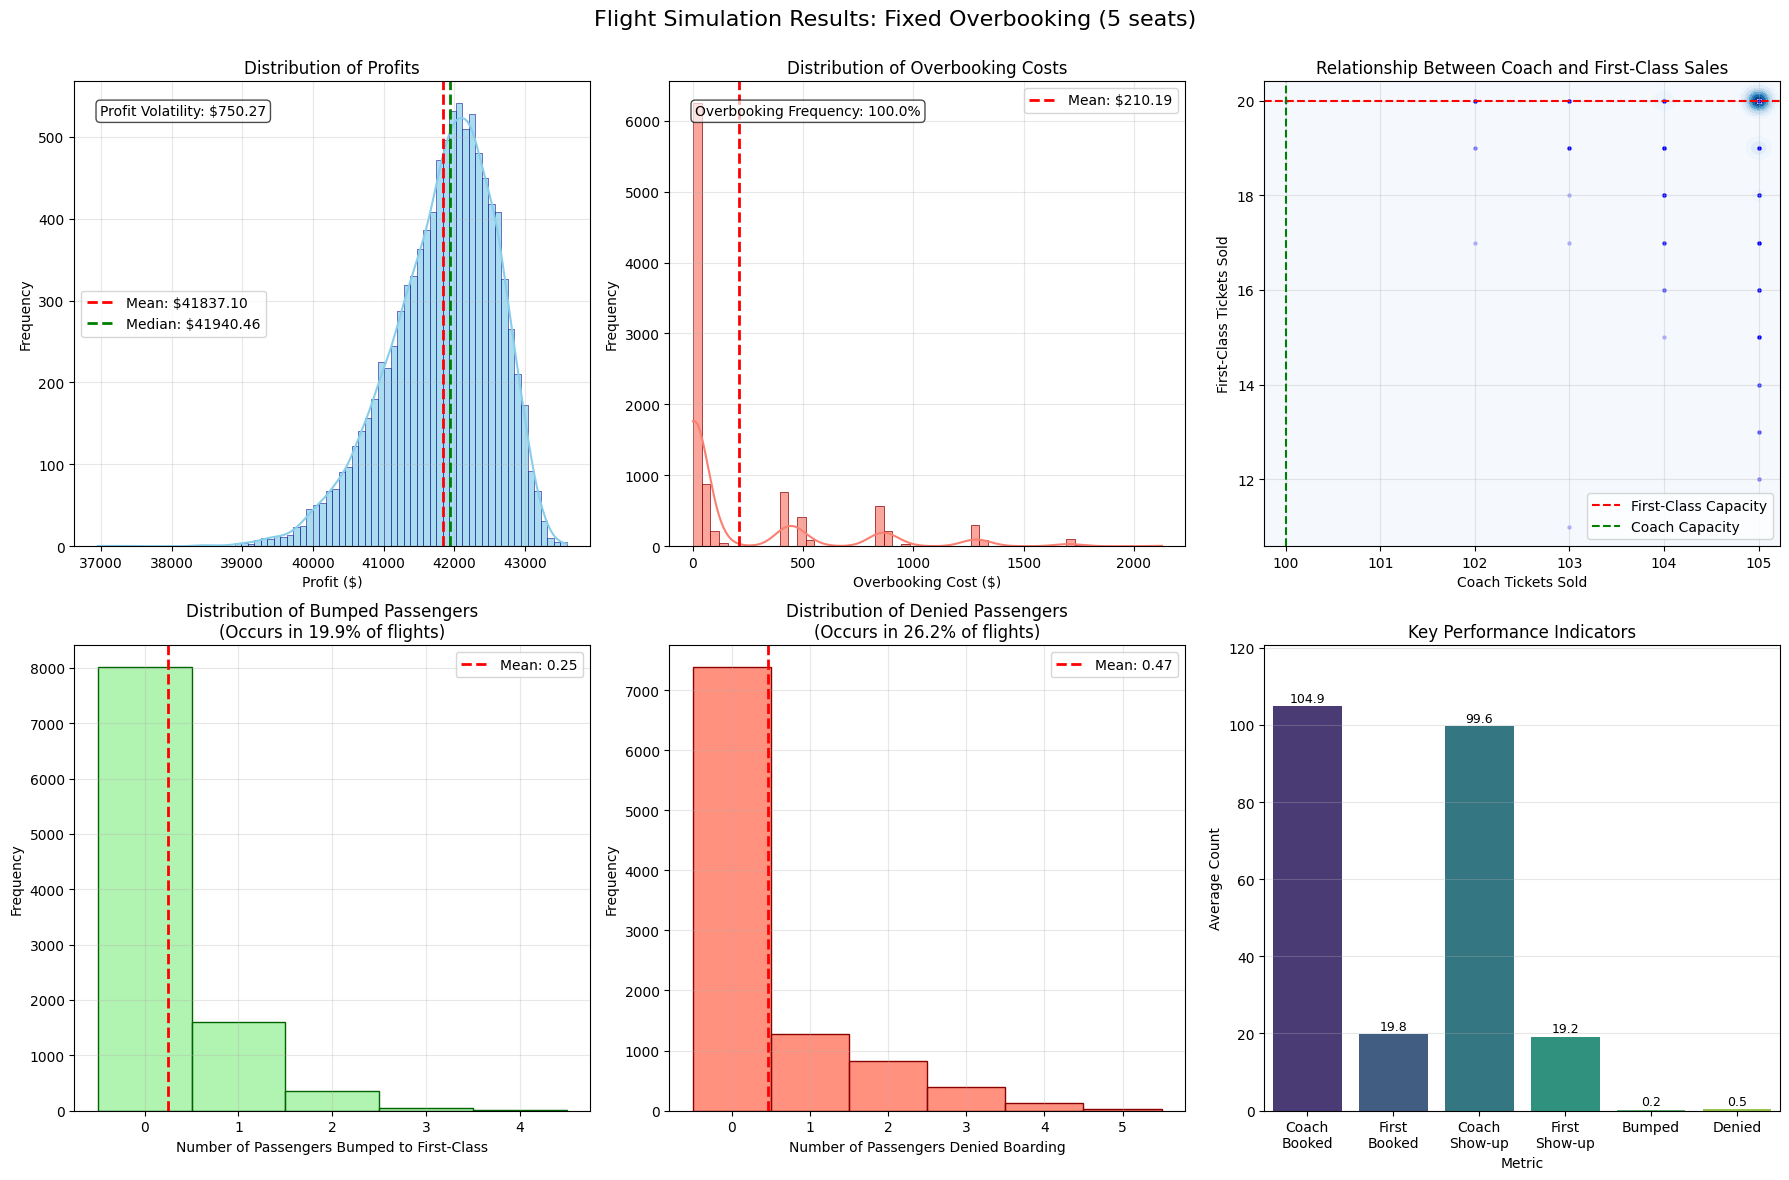

In [3]:
# Scenario 1
profit1, V1, U1 = calculate_expected_profit(overbooking_level=5)
print(f"Expected discounted profit with {5} oversold seats: ${profit1:.2f}")
print('\n')

results1 = simulate_flights(nsim=10000, U=U1, allow_no_coach_sale=False, seasonal_demand=False)

## Question 2

In [ ]:
# Scenario 2
# Calculate results for each overbooking level
overbooking_results = {}
for overbooking in range(5, 16):  # 5 to 15 inclusive
    profit, V, U = calculate_expected_profit(overbooking_level=overbooking)
    overbooking_results[overbooking] = profit
    print(f"Expected discounted profit with {overbooking} oversold seats: ${profit:.2f}")

# Find the optimal overbooking policy
optimal_overbooking = max(overbooking_results, key=overbooking_results.get)
print(f"\nOptimal overbooking policy: {optimal_overbooking} seats")
print(f"Maximum expected profit: ${overbooking_results[optimal_overbooking]:.2f}")

# Convert the results to a DataFrame for easier plotting
overbooking_df = pd.DataFrame({
    'Overbooking Level': list(overbooking_results.keys()),
    'Expected Profit': list(overbooking_results.values())
})

display(overbooking_df)

# Create the figure
plt.figure(figsize=(10, 6))

# Create a line plot with markers
sns.lineplot(data=overbooking_df, x='Overbooking Level', y='Expected Profit', 
             marker='o', linewidth=2, markersize=8)

# Highlight the optimal point
optimal_point = overbooking_df[overbooking_df['Overbooking Level'] == optimal_overbooking]
plt.plot(optimal_point['Overbooking Level'], optimal_point['Expected Profit'], 
         'ro', markersize=12, label=f'Optimal: {optimal_overbooking} seats')

# Add text label for the optimal value
plt.text(optimal_overbooking, overbooking_results[optimal_overbooking] + 100,
         f'${overbooking_results[optimal_overbooking]:.2f}',
         ha='center', va='bottom', fontweight='bold')

# Add labels and title
plt.xlabel('Overbooking Level')
plt.ylabel('Expected Profit ($)')
plt.title('Expected Profit by Overbooking Level')
plt.xticks(range(5, 16))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

# Save the best results
profit2, V2, U2 = calculate_expected_profit(overbooking_level=optimal_overbooking)

# Simulate outcome for best policy
results2 = simulate_flights(nsim=10000, U=U2, allow_no_coach_sale=False, seasonal_demand=False)

Expected discounted profit with 5 oversold seats: $41886.16


## Question 3

Expected discounted profit with 20 oversold seats and option to not sell coach ticket: $42139.89
Frequency of overbooking: 100.00%
Frequency of upgrades to first-class: 49.63%
Frequency of denials: 68.72%
Average passengers bumped to first-class: 0.80
Average passengers denied boarding: 2.20
Average overbooking cost: $974.98
Average profit: $41977.26
Profit volatility (std dev): $996.17
Average coach tickets sold: 108.18
Average first-class tickets sold: 19.55


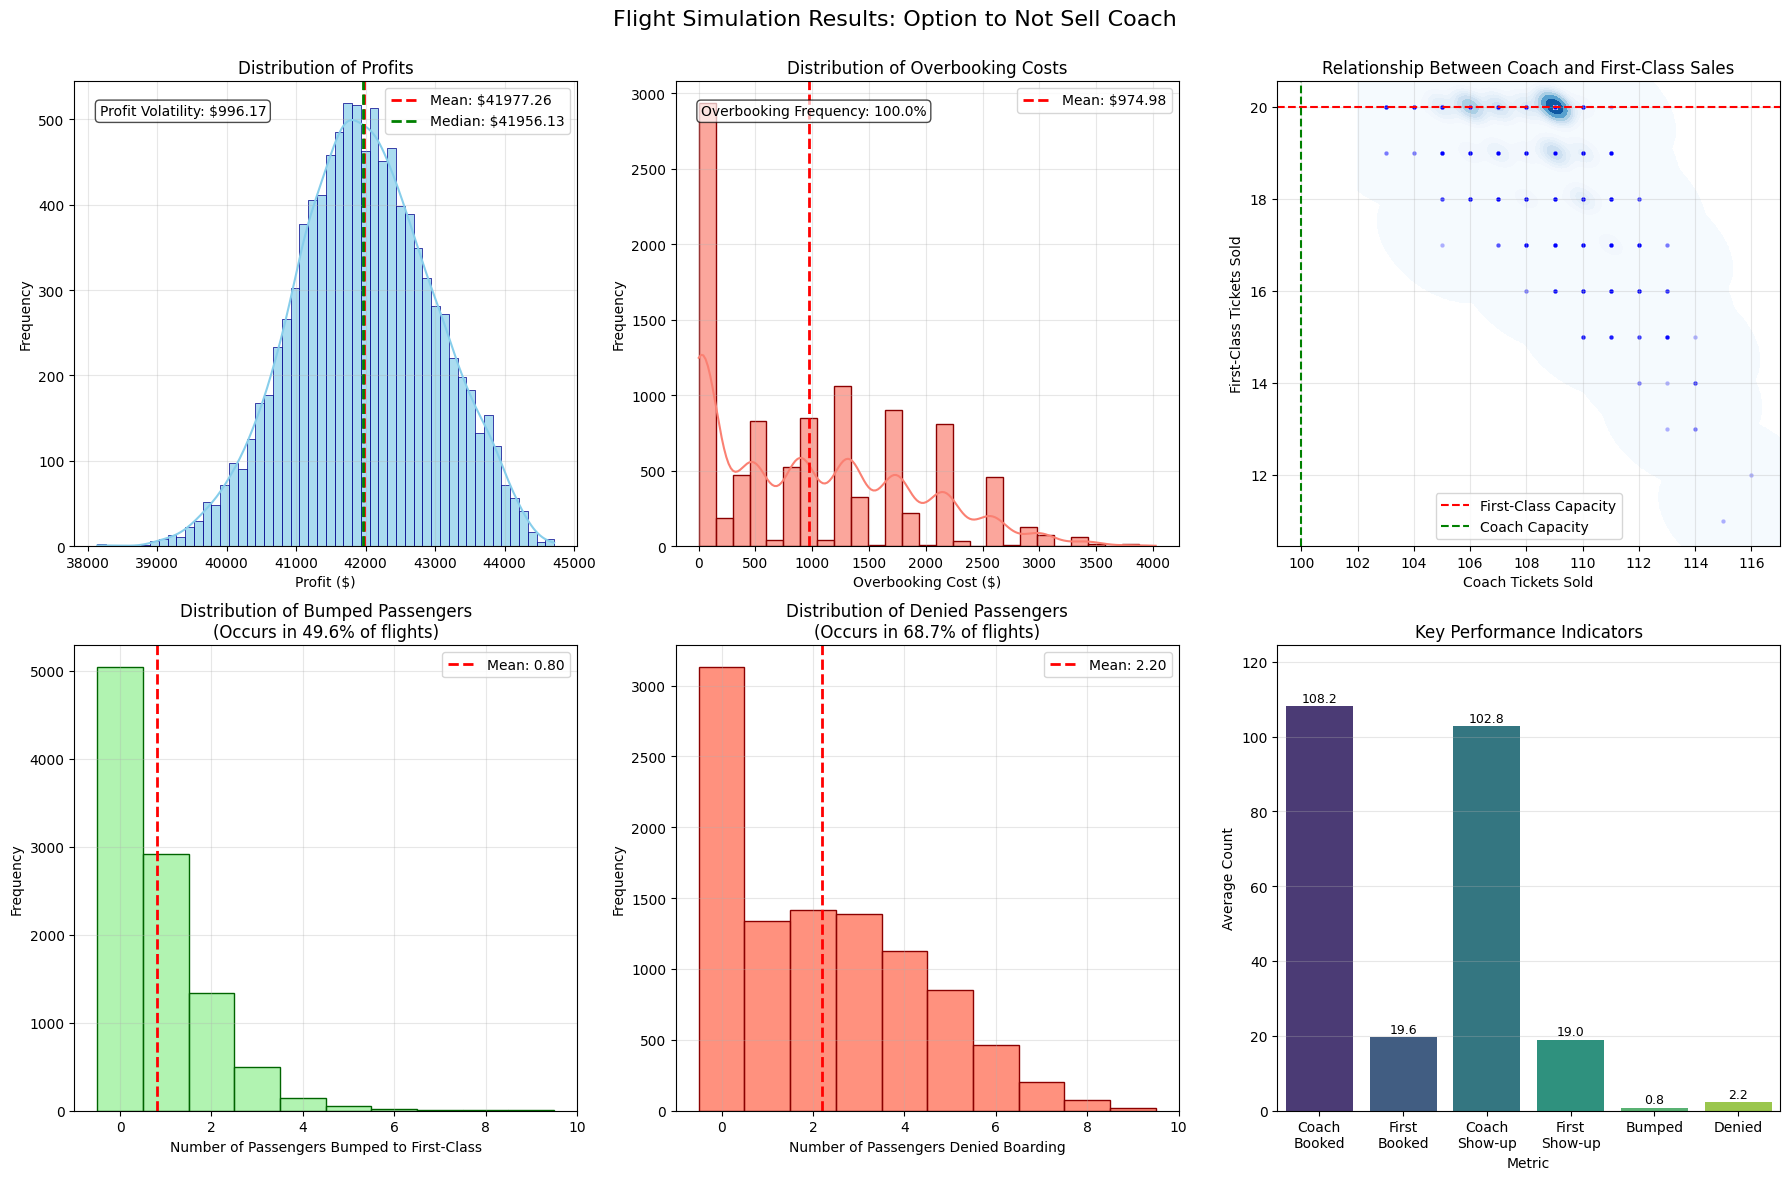

In [ ]:
# Scenario 3 (additional choice: don't sell coach ticket)
profit3, V3, U3 = calculate_expected_profit(overbooking_level=20,allow_no_coach_sale=True, seasonal_demand=False)
print(f"Expected discounted profit with {20} oversold seats and option to not sell coach ticket: ${profit3:.2f}")

results3 = simulate_flights(nsim=10000, U=U3, allow_no_coach_sale=True, seasonal_demand=False)

In [ ]:
# What is the optimal decision?
# Not running because it's slow and profit is constant beyond a certain level of overbooking

# Calculate results for each overbooking level
# print('Testing optimal overbooking level with option to not sell coach ticket')
# overbooking_results = {}
# for overbooking in range(5, 21):  # 5 to 20 inclusive (tested up to 30 and value remains the same after 15)
#     profit, V, U = calculate_expected_profit(overbooking_level=overbooking,allow_no_coach_sale=True)
#     overbooking_results[overbooking] = profit
#     print(f"Expected discounted profit with {overbooking} oversold seats: ${profit:.2f}")

# # Find the optimal overbooking policy
# optimal_overbooking = max(overbooking_results, key=overbooking_results.get)
# print(f"\nOptimal overbooking policy when you have the option to not sell coach ticket: {optimal_overbooking} seats")
# print(f"Maximum expected profit: ${overbooking_results[optimal_overbooking]:.2f}")

# # Convert the results to a DataFrame for easier plotting
# overbooking_df = pd.DataFrame({
#     'Overbooking Level': list(overbooking_results.keys()),
#     'Expected Profit': list(overbooking_results.values())
# })

# display(overbooking_df)

# # Create the figure
# plt.figure(figsize=(10, 6))

# # Create a line plot with markers
# sns.lineplot(data=overbooking_df, x='Overbooking Level', y='Expected Profit', 
#              marker='o', linewidth=2, markersize=8)

# # Highlight the optimal point
# optimal_point = overbooking_df[overbooking_df['Overbooking Level'] == optimal_overbooking]
# plt.plot(optimal_point['Overbooking Level'], optimal_point['Expected Profit'], 
#          'ro', markersize=12, label=f'Optimal: {optimal_overbooking} seats')

# # Add text label for the optimal value
# plt.text(optimal_overbooking, overbooking_results[optimal_overbooking] + 100,
#          f'${overbooking_results[optimal_overbooking]:.2f}',
#          ha='center', va='bottom', fontweight='bold')

# # Add labels and title
# plt.xlabel('Overbooking Level')
# plt.ylabel('Expected Profit ($)')
# plt.title('Expected Profit by Overbooking Level')
# plt.xticks(range(5, 16))
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.ylim(40000, 44000)
# plt.legend()

# plt.tight_layout()
# plt.show()

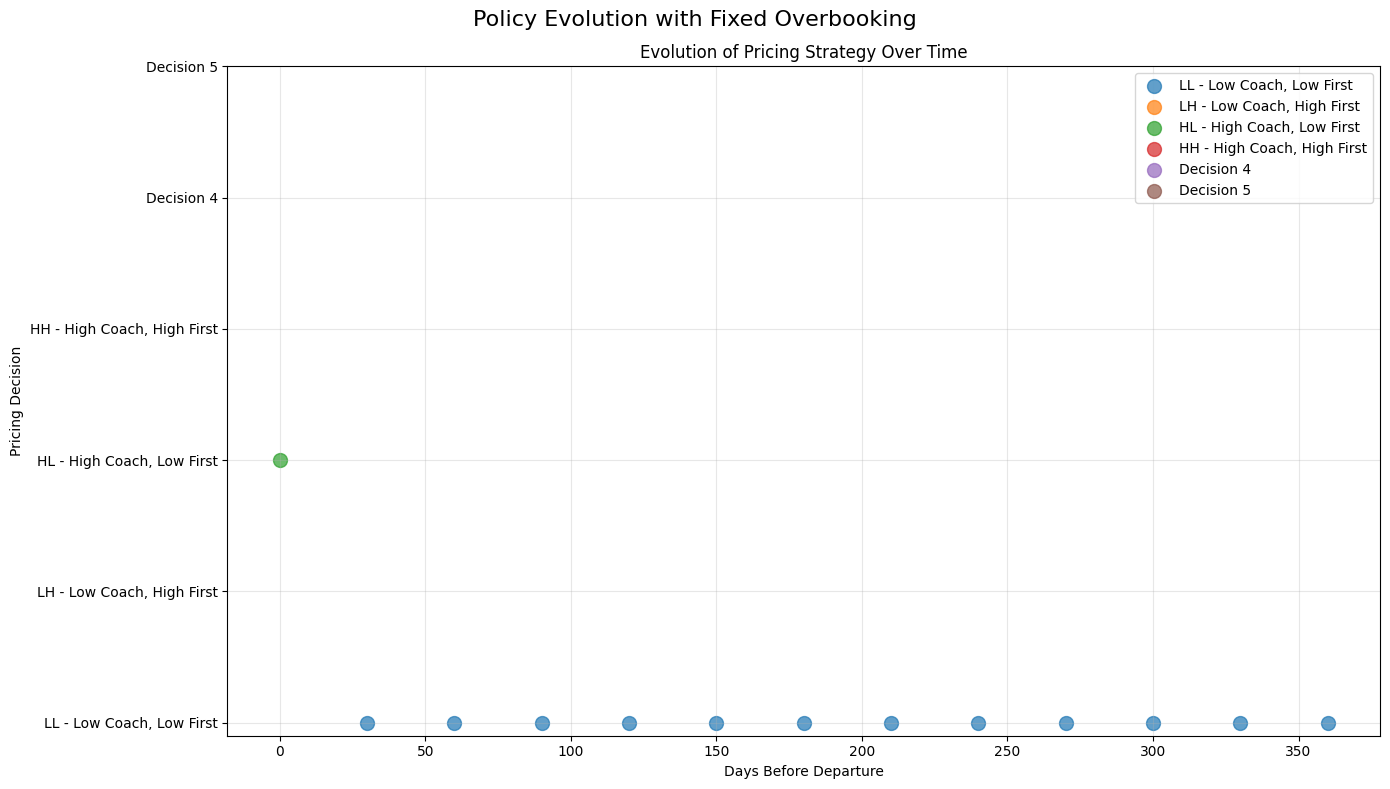

In [ ]:
# Additional analysis for scenario 3
# Need to work on this more!
def analyze_policy_decisions(U, allow_no_coach_sale=False):
    """
    Analyze the optimal policy decisions over time
    
    Returns dictionaries with:
    - Decision frequencies at each time point
    - When coach capacity typically sells out
    - When first-class capacity typically sells out
    """
    days = U.shape[0]
    decisions_over_time = {}
    
    # Initialize counters
    if allow_no_coach_sale:
        # Track LL, LH, HL, HH, NL, NH, etc.
        decision_types = {i: [] for i in range(12)}
    else:
        # Track LL, LH, HL, HH, etc.
        decision_types = {i: [] for i in range(9)}
    
    # For each day, count frequencies of each decision at state (0,0)
    # This starting state is chosen since it represents the beginning of sales
    t_values = list(range(0, days, 30))  # Sample every 30 days for readability
    
    for t in t_values:
        c, f = 0, 0  # Start with no tickets sold
        decision = int(U[t, c, f])
        if t not in decisions_over_time:
            decisions_over_time[t] = {}
        
        # Count this decision
        if decision not in decisions_over_time[t]:
            decisions_over_time[t][decision] = 0
        decisions_over_time[t][decision] += 1
        
        # Track decision type frequency over time
        decision_types[decision].append(t)
    
    return decisions_over_time, decision_types

def plot_policy_evolution(U, allow_no_coach_sale=False):
    """
    Visualize how the policy decisions evolve over time
    """
    decisions_over_time, decision_types = analyze_policy_decisions(U, allow_no_coach_sale)
    
    # Plot the decisions over time
    plt.figure(figsize=(14, 8))
    
    # Define decision labels based on the policy type
    if allow_no_coach_sale:
        decision_labels = {
            0: 'LL - Low Coach, Low First', 
            1: 'LH - Low Coach, High First',
            2: 'HL - High Coach, Low First', 
            3: 'HH - High Coach, High First',
            4: 'NL - No Coach, Low First',
            5: 'NH - No Coach, High First'
        }
    else:
        decision_labels = {
            0: 'LL - Low Coach, Low First', 
            1: 'LH - Low Coach, High First',
            2: 'HL - High Coach, Low First', 
            3: 'HH - High Coach, High First'
        }
    
    # Plot each decision type
    for decision, times in decision_types.items():
        if decision < 6:  # Show only main decision types for clarity
            plt.scatter(times, [decision] * len(times), label=decision_labels.get(decision, f"Decision {decision}"),
                       s=100, alpha=0.7)
    
    plt.yticks(range(6), [decision_labels.get(i, f"Decision {i}") for i in range(6)])
    plt.xlabel('Days Before Departure')
    plt.ylabel('Pricing Decision')
    plt.title('Evolution of Pricing Strategy Over Time')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    policy_name = "with Option to Not Sell Coach" if allow_no_coach_sale else "with Fixed Overbooking"
    plt.suptitle(f'Policy Evolution {policy_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_policy_evolution(U=U3, allow_no_coach_sale=False)


## Question 4

Expected discounted profit with 20 oversold seats, option to not sell coach ticket, and demand seasonality: $41830.46
Frequency of overbooking: 100.00%
Frequency of upgrades to first-class: 51.01%
Frequency of denials: 68.45%
Average passengers bumped to first-class: 0.83
Average passengers denied boarding: 2.15
Average overbooking cost: $955.37
Average profit: $41665.26
Profit volatility (std dev): $979.21
Average coach tickets sold: 108.14
Average first-class tickets sold: 19.53


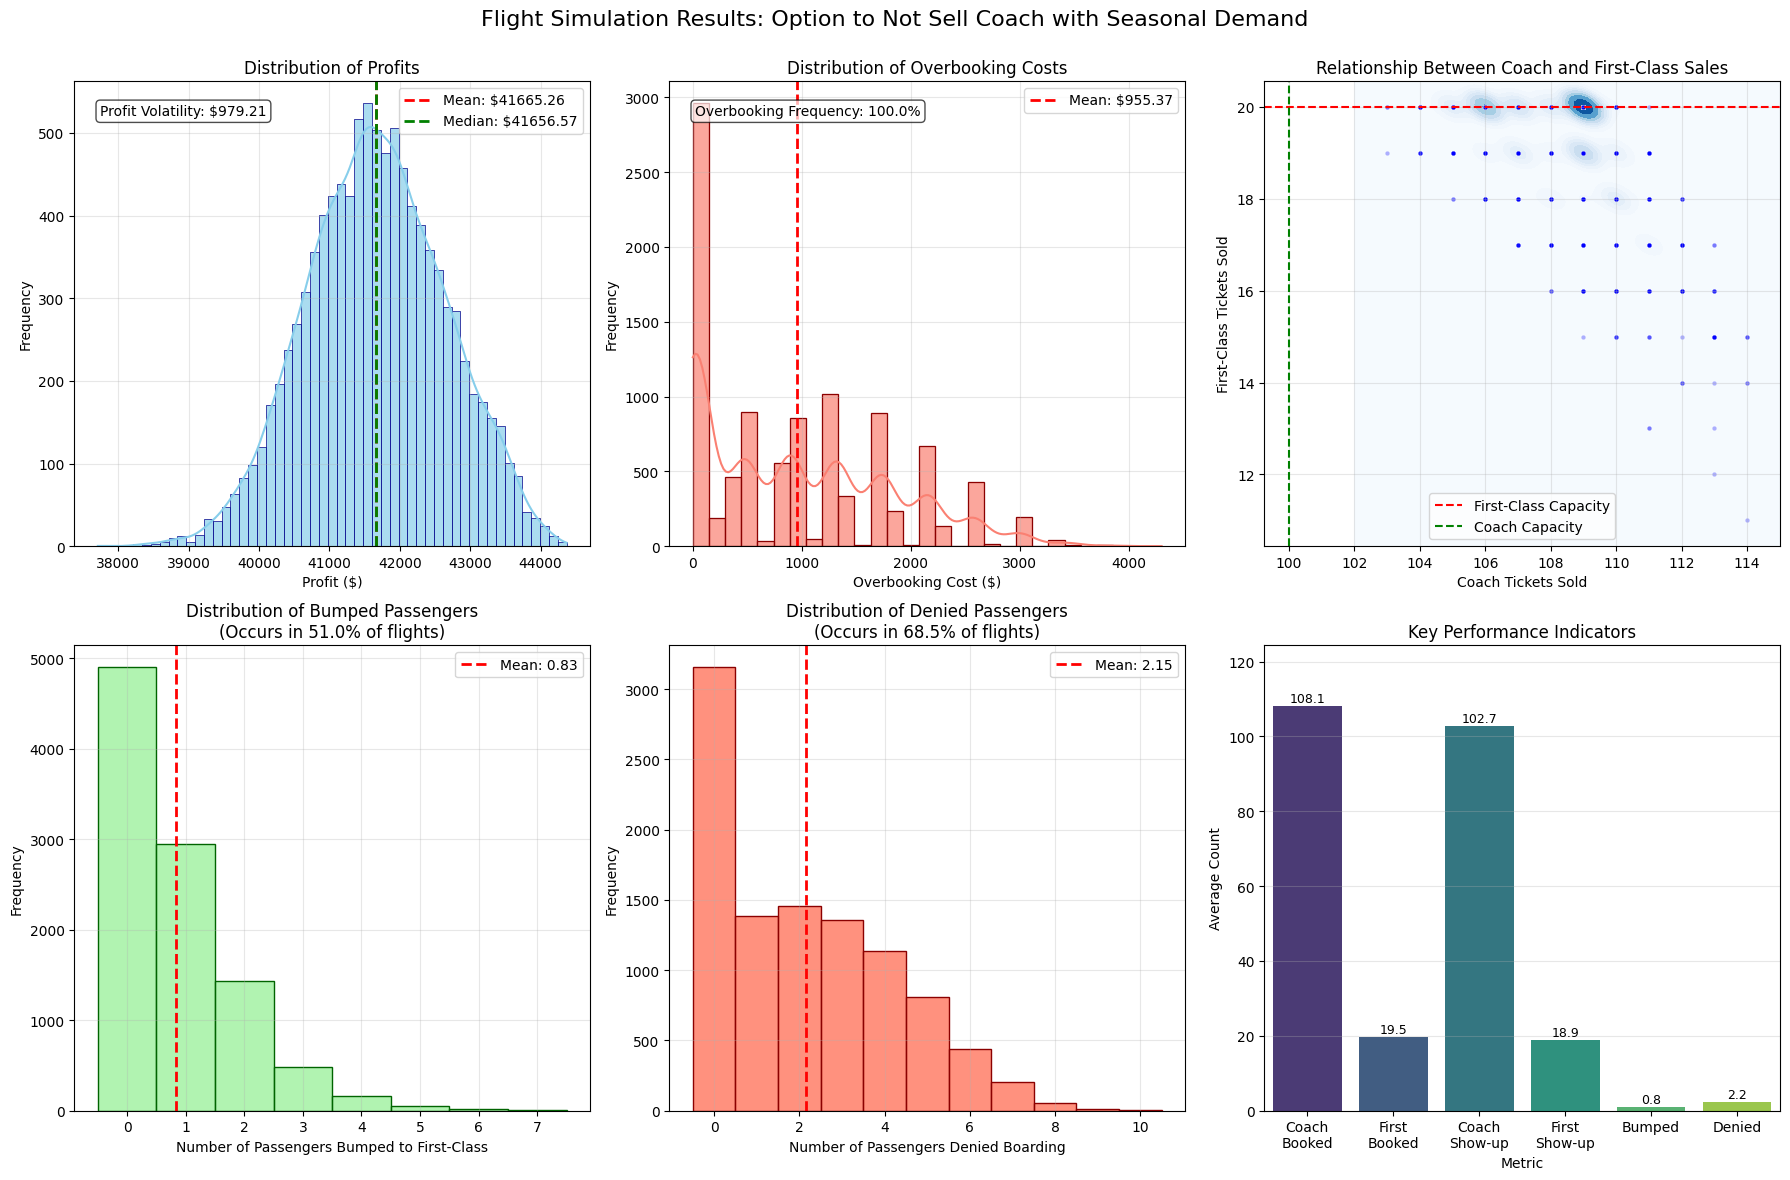

In [ ]:
# Scenario 4 (with seasonal demand)
profit4, V4, U4 = calculate_expected_profit(overbooking_level=20,allow_no_coach_sale=True,seasonal_demand=True)
print(f"Expected discounted profit with {20} oversold seats, option to not sell coach ticket, and demand seasonality: ${profit4:.2f}")

results4 = simulate_flights(nsim=10000, U=U4, allow_no_coach_sale=True, seasonal_demand=True)

In [ ]:
# Not running because it's slow and profit is constant beyond a certain level of overbooking
# What is the optimal overbooking level when you can decide not to sell a coach ticket and demand is seasonal?
# Calculate results for each overbooking level
# print('Testing optimal overbooking level with option to not sell coach ticket')
# overbooking_results = {}
# for overbooking in range(15, 26):  # 15 to 26 inclusive (no change beyond 17)
#     profit, V, U = calculate_expected_profit(overbooking_level=overbooking,allow_no_coach_sale=True,seasonal_demand=True)
#     overbooking_results[overbooking] = profit
#     print(f"Expected discounted profit with {overbooking} oversold seats: ${profit:.2f}")

# # Find the optimal overbooking policy
# optimal_overbooking = max(overbooking_results, key=overbooking_results.get)
# print(f"\nOptimal overbooking policy when you have the option to not sell coach ticket: {optimal_overbooking} seats")
# print(f"Maximum expected profit: ${overbooking_results[optimal_overbooking]:.2f}")

# # Convert the results to a DataFrame for easier plotting
# overbooking_df = pd.DataFrame({
#     'Overbooking Level': list(overbooking_results.keys()),
#     'Expected Profit': list(overbooking_results.values())
# })

# display(overbooking_df)

# # Create the figure
# plt.figure(figsize=(10, 6))

# # Create a line plot with markers
# sns.lineplot(data=overbooking_df, x='Overbooking Level', y='Expected Profit', 
#              marker='o', linewidth=2, markersize=8)

# # Highlight the optimal point
# optimal_point = overbooking_df[overbooking_df['Overbooking Level'] == optimal_overbooking]
# plt.plot(optimal_point['Overbooking Level'], optimal_point['Expected Profit'], 
#          'ro', markersize=12, label=f'Optimal: {optimal_overbooking} seats')

# # Add text label for the optimal value
# plt.text(optimal_overbooking, overbooking_results[optimal_overbooking] + 100,
#          f'${overbooking_results[optimal_overbooking]:.2f}',
#          ha='center', va='bottom', fontweight='bold')

# # Add labels and title
# plt.xlabel('Overbooking Level')
# plt.ylabel('Expected Profit ($)')
# plt.title('Expected Profit by Overbooking Level')
# plt.xticks(range(5, 16))
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.ylim(40000, 44000)
# plt.legend()

# plt.tight_layout()
# plt.show()

## Question 5
(Refer to the figures above for each question and the figure below)

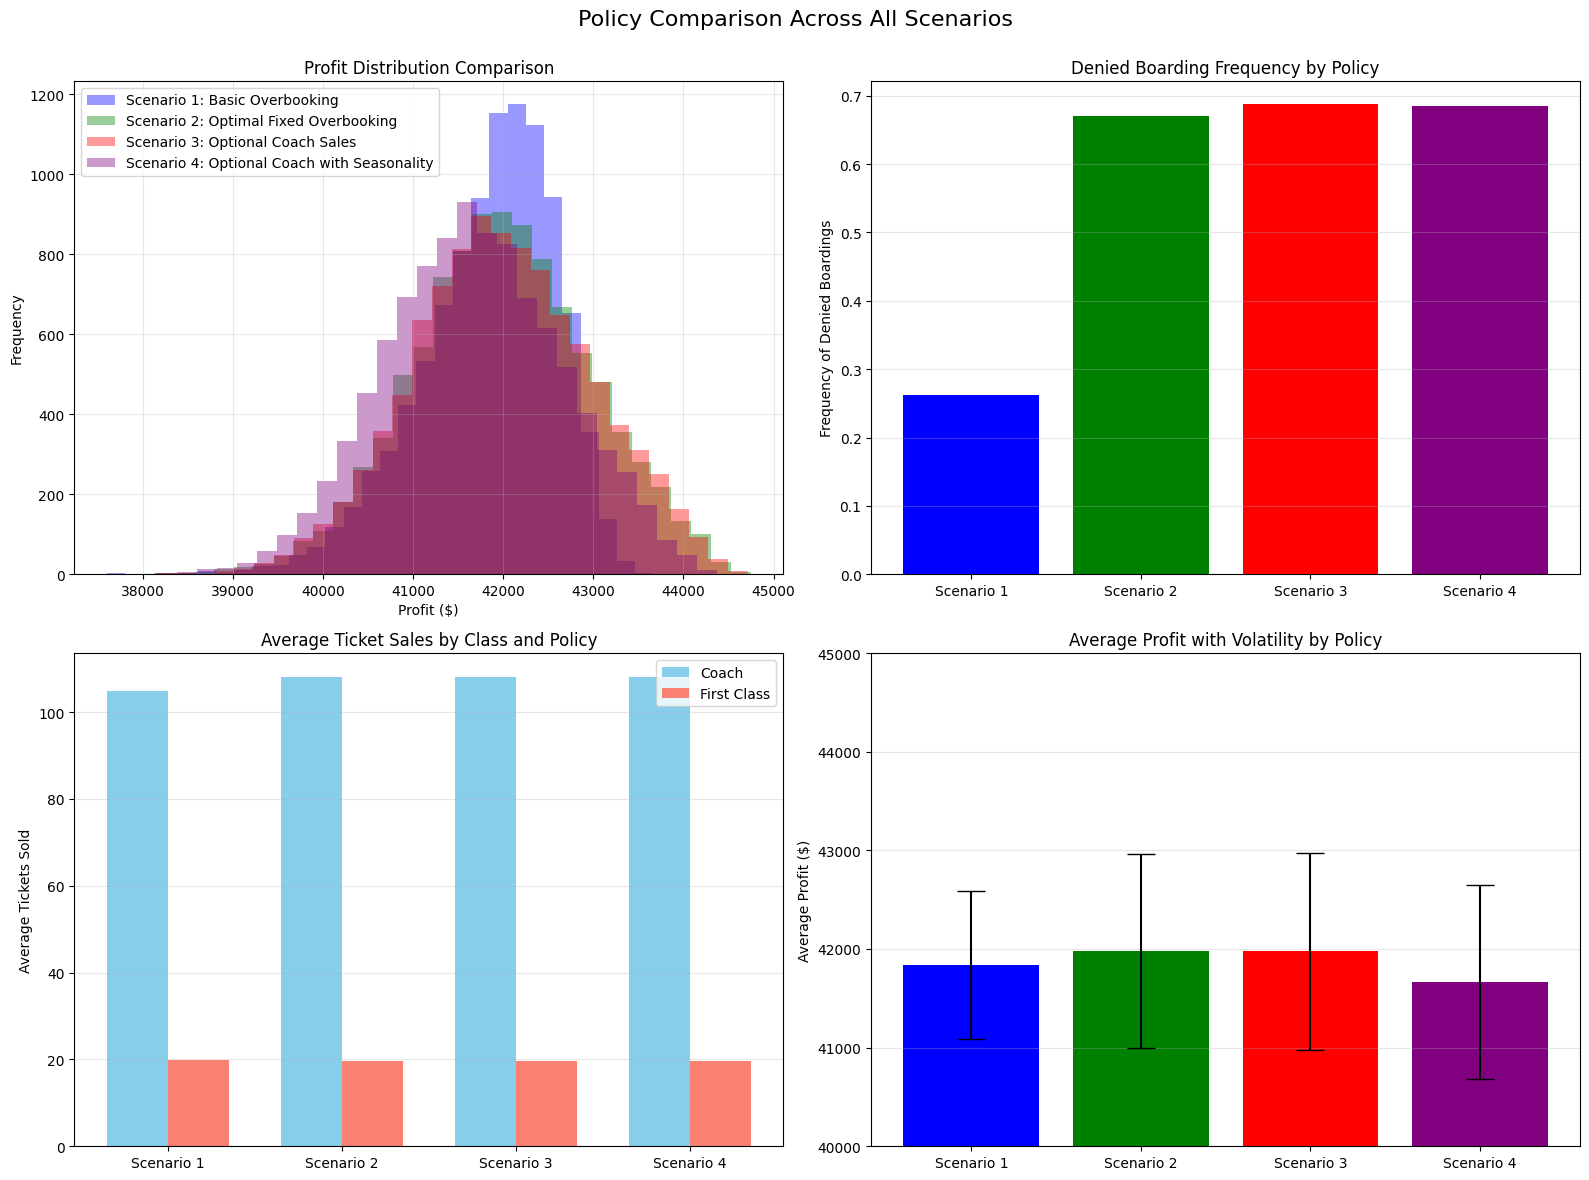

In [ ]:
# Compare all policies
def compare_policies(results1, results2, results3, results4):
    """
    Compare the results of the four different policies
    """
    # Create a figure for comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Compare profit distributions
    axes[0, 0].hist(results1['profit_array'], bins=30, alpha=0.4, color='blue', 
                  label='Scenario 1: Basic Overbooking')
    axes[0, 0].hist(results2['profit_array'], bins=30, alpha=0.4, color='green', 
                  label='Scenario 2: Optimal Fixed Overbooking')
    axes[0, 0].hist(results3['profit_array'], bins=30, alpha=0.4, color='red', 
                  label='Scenario 3: Optional Coach Sales')
    axes[0, 0].hist(results4['profit_array'], bins=30, alpha=0.4, color='purple', 
                  label='Scenario 4: Optional Coach with Seasonality')
    axes[0, 0].set_xlabel('Profit ($)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Profit Distribution Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Compare denied boarding frequencies
    denied_freq = [
        np.sum(results1['denied_array'] > 0) / len(results1['denied_array']),
        np.sum(results2['denied_array'] > 0) / len(results2['denied_array']),
        np.sum(results3['denied_array'] > 0) / len(results3['denied_array']),
        np.sum(results4['denied_array'] > 0) / len(results4['denied_array'])
    ]
    axes[0, 1].bar(['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4'], 
                  denied_freq, color=['blue', 'green', 'red', 'purple'])
    axes[0, 1].set_ylabel('Frequency of Denied Boardings')
    axes[0, 1].set_title('Denied Boarding Frequency by Policy')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Compare average ticket sales
    avg_coach = [
        np.mean(results1['coach_sold_array']),
        np.mean(results2['coach_sold_array']),
        np.mean(results3['coach_sold_array']),
        np.mean(results4['coach_sold_array'])
    ]
    avg_first = [
        np.mean(results1['first_sold_array']),
        np.mean(results2['first_sold_array']),
        np.mean(results3['first_sold_array']),
        np.mean(results4['first_sold_array'])
    ]
    
    x = np.arange(4)
    width = 0.35
    axes[1, 0].bar(x - width/2, avg_coach, width, label='Coach', color='skyblue')
    axes[1, 0].bar(x + width/2, avg_first, width, label='First Class', color='salmon')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4'])
    axes[1, 0].set_ylabel('Average Tickets Sold')
    axes[1, 0].set_title('Average Ticket Sales by Class and Policy')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Compare profit statistics
    avg_profits = [
        np.mean(results1['profit_array']),
        np.mean(results2['profit_array']),
        np.mean(results3['profit_array']),
        np.mean(results4['profit_array'])
    ]
    std_profits = [
        np.std(results1['profit_array']),
        np.std(results2['profit_array']),
        np.std(results3['profit_array']),
        np.std(results4['profit_array'])
    ]
    
    axes[1, 1].bar(['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4'], 
                  avg_profits, yerr=std_profits, capsize=10, 
                  color=['blue', 'green', 'red', 'purple'])
    axes[1,1].set_ylim(40000, 45000)
    axes[1, 1].set_ylabel('Average Profit ($)')
    axes[1, 1].set_title('Average Profit with Volatility by Policy')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.suptitle('Policy Comparison Across All Scenarios', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

compare_policies(results1, results2, results3, results4)

### Potential Additional Questions for Part 5

1. Temporal patterns in ticket sales:

    - How many days before departure do coach and first-class typically sell out?
    - Is there a pattern to when the airline chooses to not sell coach tickets (in Scenario 3)?
    - What percentage of total tickets are sold in the last 30, 60, or 90 days before departure?

2. Pricing strategy evolution:

    - How does the pricing strategy evolve over time? You could create a visualization showing the frequency of each pricing decision (LL, LH, HL, HH) as a function of time before departure.
    - When does the airline switch from low to high pricing for each class?
    - In seasonal demand scenarios, how does the pricing strategy adapt?

3. Overbooking risk analysis:

    - What is the relationship between profit and overbooking risk (e.g., denied boardings)?
    - How does variability in show-up rates affect the optimal policy? (You could run sensitivity analyses)
    - What's the tradeoff between number of denied boardings and profit?


4. Revenue management efficiency:

    - What's the aircraft utilization rate (percentage of seats filled) for each policy?
    - How does load factor correlate with profitability?
    - What percentage of revenue comes from each ticket class?


5. Risk profile comparison:

    - Compare the profit distributions between different overbooking policies using histograms or box plots
    - Calculate the Value at Risk (VaR) for each policy